In [30]:
import sys
import tqdm
import torch
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append('../')
import utils as ut
import extrapolation as ext

In [31]:
n_epochs = 1000
check_every = 10
n_networks = 5
rerun_KL = False

In [32]:
data = np.load(f'../extrapolation_data/1000/_{n_epochs}_{check_every}.npz')

In [33]:
list(data.keys())

['train', 'val', 'KL', 'post_samples']

ValueError: x and y must have same first dimension, but have shapes (1000,) and (100,)

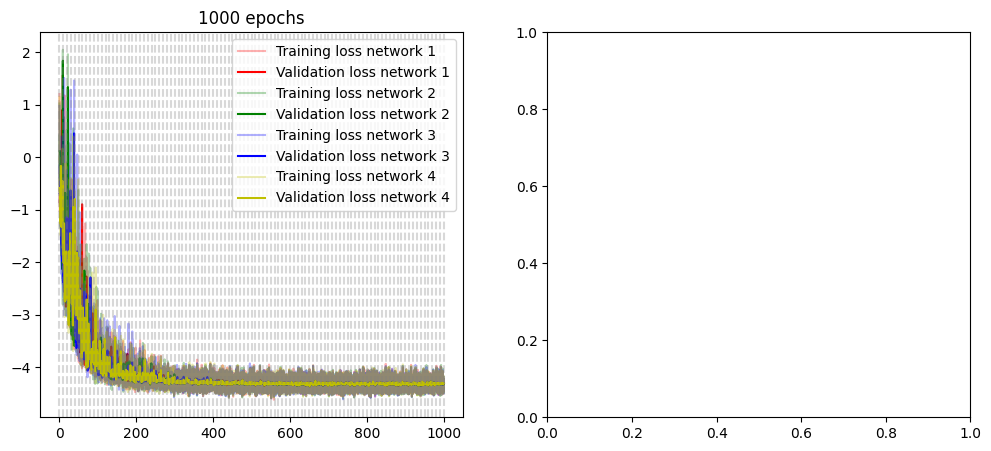

In [90]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ut.plot_losses(data['train'][1:], data['val'][1:], check_every, ax=ax[0])  
ax[0].set_title(str(n_epochs)+' epochs') 

for i in range(data['KL'][:,4:].shape[1]):
    ax[1].plot(np.arange(data['KL'][:,4+i].shape[0] * check_every), data['KL'][:,4+i], label=f"{i}")

ax[1].set_title('KL divergence')
ax[1].set_xlabel('epoch')
ax[1].set_yscale('log')

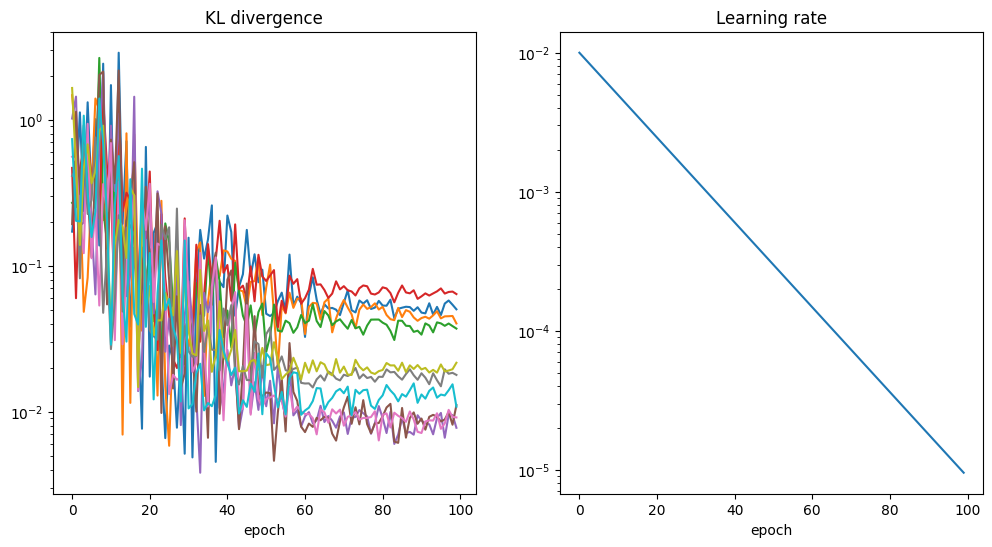

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(data['KL'].shape[1]):
    ax[0].plot(data['KL'][:,i], label=f"{i}")

ax[0].set_title('KL divergence')
ax[0].set_xlabel('epoch')
ax[0].set_yscale('log')

x = np.arange(data['KL'].shape[0])
ax[1].plot(1e-2 * .9**(x/1.5) )
ax[1].set_title('Learning rate')
ax[1].set_xlabel('epoch')
ax[1].set_yscale('log')


In [217]:
xx = torch.tensor((1 - np.abs( np.linspace(-1, 1, 10) ) **.25)) 
xx /= torch.max(xx)

In [238]:
bump_par = 3e-2


observation_theta = torch.tensor([0.1]) #ext.uniform_prior.sample((1,))
observation_data = ext.simulator(observation_theta)
full_data = observation_data + bump_par * xx
print('Observation theta:', observation_theta)

Observation theta: tensor([0.1000])


In [239]:
mean_base = float(observation_data.mean())
std = .01 / np.sqrt(10)
dd_base = np.random.normal(mean_base, std, 10000)
print('Mean base:', mean_base)
print('Std:', std)


mean_full = float(full_data.mean())
dd_full = np.random.normal(mean_full, std, 10000)
print('Mean full:', mean_full)
print('Std:', std)

Mean base: 0.1053028330206871
Std: 0.0031622776601683794
Mean full: 0.11751677260632647
Std: 0.0031622776601683794


In [240]:
density_estimators = [
        ext.density_estimator_extrapolation(
            num_samples=ext.def_batch_size,
            prior=ext.uniform_prior,
            simulator=ext.simulator,
            which_dataloader=ext.which_dataloader,
        )
        for _ in range(ext.n_networks)
    ]

In [241]:
for i in range(n_networks):
    density_estimators[i].load_state_dict(torch.load(f'../extrapolation_data/1000/network_{i}_{n_epochs}_{check_every}.pth'))

/tmp/ipykernel_127962/644264175.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  density_estimators[i].load_state_dict(torch.load(f'../extrapolation_data/1000/network_{i}

In [242]:
posteriors = []
for i in range(ext.n_networks):
    posteriors.append(ext.DirectPosterior(density_estimators[i], ext.uniform_prior))

In [243]:
p_samples_base = np.zeros((ext.n_networks, ext.n_samples))
for i in range(ext.n_networks):
    p_samples_base[i] = posteriors[i].sample(
                (ext.n_samples,), x=observation_data, show_progress_bars=False
            ).numpy()


In [244]:
pp_samples_base = [p_samples_base[i][(p_samples_base[i] > mean_base -10 *std) & (p_samples_base[i] < mean_base +10 *std )] for i in range(n_networks)]

In [245]:
p_samples_full = np.zeros((ext.n_networks, ext.n_samples))
for i in range(ext.n_networks):
    p_samples_full[i] = posteriors[i].sample(
                (ext.n_samples,), x=full_data, show_progress_bars=False
            ).numpy()

In [246]:
pp_samples_full = [p_samples_full[i][(p_samples_full[i] > mean_full -10 *std) & (p_samples_full[i] < mean_full +10 *std )] for i in range(n_networks)]

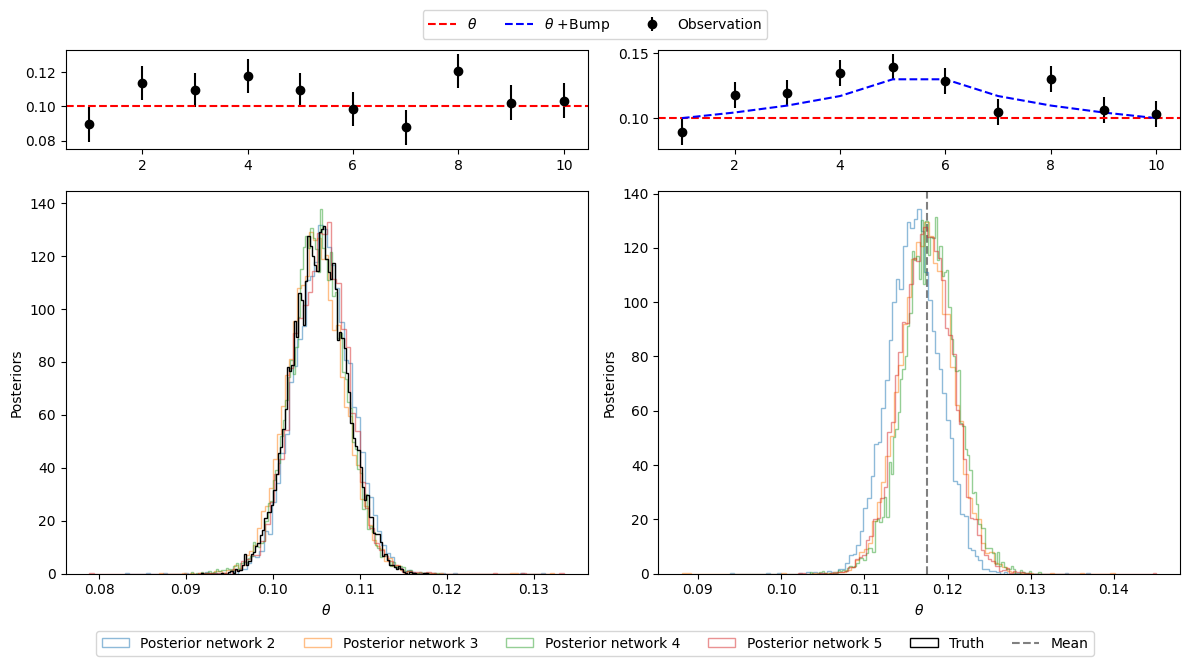

In [247]:
fig = plt.figure(figsize=(12, 6))

# Set up grid: 4 rows, 1 column (3 for main plot, 1 for small plot)
gs = gridspec.GridSpec(4, 2, figure=fig)

# Main plot takes up 3/4 of the figure
ax11 = fig.add_subplot(gs[0, 0])
ax11.errorbar(np.arange(1, 11, 1), observation_data, yerr=.01, color='black', linestyle=' ', marker='o')
ax11.axhline(observation_theta[0], color='red', linestyle='--', label=r'$\theta$')
#ax11.legend(loc=3)
#ax11.set_title('Observation')

# Smaller plot takes up 1/4 of the figure
ax12 = fig.add_subplot(gs[1:4, 0])
for i in range(1, n_networks):
    ax12.hist(pp_samples_base[i], bins=100, density=True, alpha=.5, label=f'Posterior network {i +1}', histtype='step');
ax12.hist(dd_base, bins=100, density=True, label='Truth', histtype='step', color='black');
ax12.set_xlabel(r'$\theta$')
ax12.set_ylabel('Posteriors')

# Main plot takes up 3/4 of the figure
ax21 = fig.add_subplot(gs[0, 1])
ax21.errorbar(np.arange(1, 11, 1), full_data, yerr=.01, color='black', label='Observation', linestyle=' ', marker='o')
ax21.axhline(observation_theta[0], color='red', linestyle='--')
ax21.plot(np.arange(1, 11, 1), bump_par * xx + observation_theta[0], color='blue', linestyle='--', label=r'$\theta$ +Bump')
#ax21.set_title('Observation')

# Smaller plot takes up 1/4 of the figure
ax22 = fig.add_subplot(gs[1:4, 1])
ax22.axvline(mean_full, label='Mean', color='grey', linestyle='--');
for i in range(1, n_networks):
    ax22.hist(pp_samples_full[i], bins=100, density=True, alpha=.5, histtype='step');
ax22.set_xlabel(r'$\theta$')
ax22.set_ylabel('Posteriors')

# Add common legends
handlestop, labelstop = ax11.get_legend_handles_labels()
handles_aux, labels_aux = ax21.get_legend_handles_labels()
handlestop += handles_aux
labelstop += labels_aux

fig.legend(handlestop, labelstop, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

handlesbottom, labelsbottom = ax12.get_legend_handles_labels()
handles_aux, labels_aux = ax22.get_legend_handles_labels()
handlesbottom += handles_aux
labelsbottom += labels_aux
fig.legend(handlesbottom, labelsbottom, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=7)

fig.tight_layout()
plt.savefig('final_plots/posteriors_bump.pdf', bbox_inches='tight')

In [248]:
new_observation_theta = torch.tensor([0.1])
new_observation_data = ext.simulator(new_observation_theta)

full_data = new_observation_data + xx
mean_full = float(full_data.mean())
print('Mean full:', mean_full)

Mean full: 0.5058918069088897


In [249]:
regenerate = True
nn_networks = 4
nn_combinations = int(nn_networks *(nn_networks-1) / 2)
alpha = np.geomspace(1e-2, 10, 10)
kl_vals = np.zeros((nn_combinations, len(alpha)))

try:
    if regenerate:
        raise FileNotFoundError("Regenerate KL values")
    
    kl_data = np.load('new_KL_vals.npz')
    alpha = kl_data['alpha']
    kl_vals = kl_data['kl_vals']
    print('Loaded')

except FileNotFoundError:
    for a in tqdm.tqdm(range(len(alpha))):
        full_data = new_observation_data + alpha[a] * xx
        
        k = 0
        for i in range(1, n_networks):
            for j in range(i+1, n_networks):
                kl_vals[k,a] = ext.my_KLval(posteriors[i], posteriors[j], 1e-3, 10000, observation=full_data)
                k += 1   
    np.savez('new_KL_vals.npz', alpha=alpha, kl_vals=kl_vals) 

 80%|████████  | 8/10 [06:59<01:44, 52.42s/it]


KeyboardInterrupt: 

/tmp/ipykernel_127962/981972.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


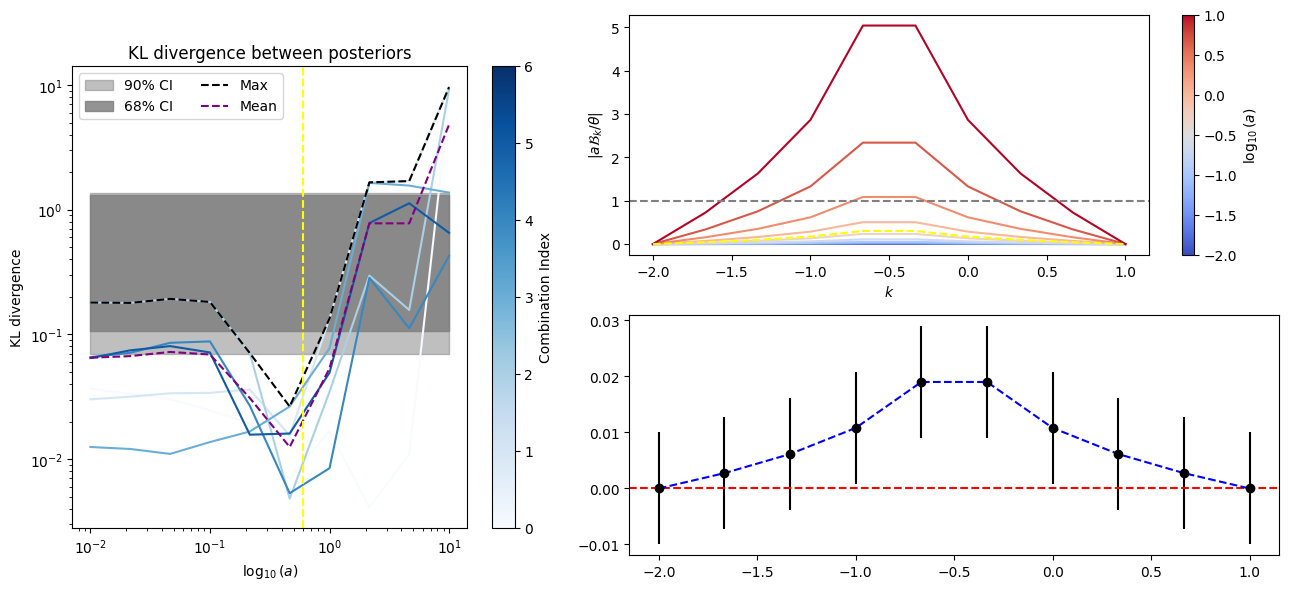

In [ ]:
from matplotlib.colors import Normalize

cmap = cm.Blues
norm = Normalize(vmin=0, vmax=nn_combinations)

vals = np.quantile(kl_vals[:,:30], [.05, .16, .5, .84, .95], axis=0)
vv = np.mean(vals, axis=-1)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))

# axs is a 2x2 array: axs[0,0], axs[0,1], axs[1,0], axs[1,1]

# Remove the two Axes in the left column
fig.delaxes(ax[0,0])
fig.delaxes(ax[1,0])

# Get the position of the old left-column Axes to compute new big Axes' position
pos_top = ax[0,0].get_position()
pos_bottom = ax[1,0].get_position()

# Compute merged position spanning top and bottom left Axes
new_pos = [
    pos_bottom.x0,   # left
    pos_bottom.y0,   # bottom
    pos_top.x1 - pos_bottom.x0,   # width
    pos_top.y1 - pos_bottom.y0    # height
]

# Add the new big Axes using the computed merged position
ax_big = fig.add_axes(new_pos)


for i in range( nn_combinations ):
    ax_big.loglog(alpha, kl_vals[i,:], color=cmap(norm(i))) 

ax_big.fill_between(alpha, vv[0], vv[-1], alpha=.5, color='grey', label='90% CI')
ax_big.fill_between(alpha, vv[1], vv[-2], alpha=.85, color='grey', label='68% CI')
ax_big.loglog(alpha, np.max(kl_vals, axis=0), label='Max', color='black', linestyle='--')
ax_big.loglog(alpha, np.mean(kl_vals, axis=0), label='Mean', color='purple', linestyle='--')

# Add a custom legend entry for the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax_big, label="Combination Index")

ax_big.axvline(.6, color='yellow', linestyle='--')

ax_big.set_xscale('log')
ax_big.set_xlabel(r'$\log_{10}(a)$')
ax_big.set_ylabel('KL divergence')
ax_big.set_title('KL divergence between posteriors')
ax_big.legend(ncol=2)


aa = np.log10(np.geomspace(alpha[0], alpha[-1], 10)) #  np.array(alpha) # 
cmap = cm.coolwarm
norm = Normalize(vmin=aa[0], vmax=aa[-1])


for a in aa:
    ax[0,1].plot(aa, 10**a * xx / np.abs( observation_theta[0] ) , color=cmap(norm(a)), label=f'{a}')

ax[0,1].plot(aa, .6 * xx / np.abs( observation_theta[0] ) , color='yellow', linestyle='--')

# Add a custom legend entry for the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax[0,1], label=r"$\log_{10}(a)$")

ax[0,1].axhline(1., color='grey', linestyle='--', label=r'$\theta$')
ax[0,1].set_ylabel(r'$|a \mathcal{B}_k / \theta |$')
# ax[0,1].set_ylim(-3, 3)
ax[0,1].set_xlabel(r'$k$')

ax[1,1].errorbar(aa, .6 * xx + new_observation_theta[0], yerr=.01, color='black', label='Bump', linestyle=' ', marker='o')
ax[1,1].axhline(new_observation_theta[0], color='red', linestyle='--')
ax[1,1].plot(aa, .6 * xx + new_observation_theta[0], color='blue', linestyle='--', label=r'$\theta$ +Bump')

plt.tight_layout()